## Goal
Apply Decision Trees on Amazon Food reviews.
1. Since the number of vectors in BoW and tfIDF is large, apply DT on Average Word2Vec & tfIDF Word2Vec
2. Train/Test split using time based slicing as a 70-30 split
3. Use GridSearchCV to find the optimal depth


### Data
The Amazon fine food reviews dataset is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/database.sqlite/2). The SQLLite version(database.sqlite) of the dataset is used. A folder called 'amazon-fine-food-reviews' needs to be created in the working directory and downloaded to that folder.

Google Word2Vec (GoogleNews-vectors-negative300.bin) is also used and those are available [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus, collections


from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer, roc_curve, auc
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import itertools, pickle, random, sqlite3, nltk, string, re
from pathlib import Path
from scipy import sparse
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
from datetime import datetime, timedelta

### Load Data

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not considering those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#change reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print ('Total number of reviews is {} with {} features each'.format(*filtered_data.shape))
filtered_data.head()

Total number of reviews is 525814 with 10 features each


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA

#### Remove Duplicates

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#### Data Cleanup

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Note:
The dataset is imbalanced. So the metric to evaluate the model should not be accuracy, it could be confusion matrix 

### PreProcessing

#### Stemming, Stop word remove and Lemmatization

In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print('The stop words are \n {}'.format(stop))
print('************************************************************')
print('The stem word for tasty is {}'.format(sno.stem('tasty')))

The stop words are 
 {'this', 'myself', 'how', "shouldn't", 'any', 'no', 'o', 'be', 'of', 'with', 'does', 'me', "couldn't", 'because', 'off', 'which', 'doesn', 'that', 'each', 'we', "needn't", 'our', 'a', 'he', "doesn't", 'these', 'm', "won't", 'same', "isn't", 'themselves', 'such', 'both', 't', 'yours', 'wouldn', 'only', 'mightn', "you're", 'ours', 'did', 'most', "that'll", 'isn', 'own', "weren't", "don't", 'what', 'ourselves', 'there', 'it', 'against', 'you', 'if', "wasn't", 'is', 'why', 'are', 'out', 'theirs', 'mustn', 'needn', 'ain', "shan't", 'should', 'by', 'his', 'who', 'am', 'my', 'about', 'below', 'more', 'ma', 'while', 'her', 'those', 'here', 'or', 'shouldn', 'other', 'll', 'some', 'before', "should've", 'd', 'to', 'couldn', 'then', 'whom', 'your', 'over', 'himself', 'him', 'in', 'into', 'as', 'were', 're', 'few', 'further', 'shan', 'up', 'under', "mustn't", 'until', "she's", 'than', 'aren', 'weren', 'hers', 'has', 'once', 'all', 'now', 'having', 'they', 'on', 'when', 'the', 

We need 3 types of cleaned data so we will use 3 different variables to store this data:
1. For Bag of Words and TfIDF we need the stop words to be removed and stemmed
2. For Bigrams and trigrams we do not need to remove the stop words but we can stem the words
3. For Avg Word2Vec and TfIDF Word2Vec we can remove the stopwords but not stem the words if we plan to use Google's word2vec model.

In [10]:
i=0
str_b=' '
str_n=' '
str_w=' '
bow_tfidf_string=[]
ngrams_string=[]
word2vec_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence_b=[]
    filtered_sentence_n=[]
    filtered_sentence_w=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence_n.append(s) #for ngrams we need stemmed words
                if(cleaned_words.lower() not in stop):
                    filtered_sentence_b.append(s) #for BoW and tfidf we need stemmed and stop words removed data
                    filtered_sentence_w.append(cleaned_words.lower().encode('utf8')) # for Word2Vec we need non stemmed and stop words removed data
                else:
                    continue
            else:
                continue 
    
    
    str_n = b" ".join(filtered_sentence_n)
    str_b = b" ".join(filtered_sentence_b)
    str_w = b" ".join(filtered_sentence_w)
    
    bow_tfidf_string.append(str_b)
    ngrams_string.append(str_n)
    word2vec_string.append(str_w)

    i+=1

In [11]:
final['BowTfIDFText']=bow_tfidf_string 
final['BowTfIDFText']=final['BowTfIDFText'].str.decode("utf-8")

# final['nGramsText']=ngrams_string 
# final['nGramsText']=final['nGramsText'].str.decode("utf-8")

final['Word2VecText']=word2vec_string 
final['Word2VecText']=final['Word2VecText'].str.decode("utf-8")

In [12]:
# store final table into an SQlLite table for future.
final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
c=final_dbconn.cursor()
final_dbconn.text_factory = str
final.to_sql('Reviews', final_dbconn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

### Time Based Slicing
The below function creates a cross validation dataset and fits the model. This will be used across BoW, tfIDF, Average Word2Vec and tfIDF Word2Vec

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          figsize = (5,3),
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.figure(figsize=(4,2))
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def fit_predict(estimator, X_train, y_train, X_test, y_test):
    # fitting the model on crossvalidation train
    estimator.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    y_pred = estimator.predict(X_test)
    
    return y_pred

### Run Classifier
Given a dataset of X, y the below function
1. Splits the dataset into train and test.

In [33]:
def split_data(data, sort_by_time='Y', test_size=0.3):
    
    if sort_by_time == 'Y':
        data = data.sort_values(by='Time')
        data.reset_index(inplace=True,drop=True)
        
    train_index = int(np.floor(data.shape[0] * (1- test_size)))

    X_train = data.loc[:train_index]
    y_train = X_train.Score
    X_train.drop(['Score'], axis=1, inplace=True)
    

    X_test = data.loc[train_index:]
    y_test = X_test.Score
    X_test.drop(['Score'], axis=1, inplace=True)
    
    return X_train, y_train, X_test, y_test

In [34]:
def plot_cv_scores(gridsearch, param, x_axis_label, y_axis_label, title):
    X = [params[param] for params in gridsearch.cv_results_['params']]
    y = [mean for mean in gridsearch.cv_results_['mean_test_score']]
    
    plt.plot(X, y)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    
    plt.title(title)
    plt.grid() 

    plt.show()

In [35]:
def plot_roc_curve(fpr, tpr, roc_auc, y_label, x_label):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [130]:
def print_top_n_features(feature_name, feature_importance, top_n):
    ex_dic = {
    'FeatureName': feature_name,
    'FeatureImp': feature_importance.tolist()
    }

    columns = ['FeatureName', 'FeatureImp']

    df = pd.DataFrame(ex_dic, columns=columns)
    df.sort_values(['FeatureImp'], ascending=False, inplace=True)
    print ('Top {} features are: \n {}'.format(top_n, df[0:top_n]))

In [133]:
def fit_and_visualize_trees(model, feature_names, file_name='tree.png'):
    export_graphviz(model, out_file=file_name)  
        
    # Visualize data
    dot_data = export_graphviz(model, 
                                   feature_names=feature_names,
                                   out_file=None,
                                   filled=True,
                                   rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])

    graph.write_png(file_name)

In [66]:
def do_paramSearch(model, param_grid, type_of_search, X_train, y_train, X_test, y_test, cv):
    if type_of_search not in ['GridSearch', 'RandomSearch']:
        print ('Allowed searches are GridSearch and RandomSearch')
        return
    
    #Use TimeSeriesSplit for cross validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    train_test_split = tscv.split(X_train)

    f1_scorer = make_scorer(f1_score, pos_label='positive')
    if type_of_search == 'GridSearch':
        gs = GridSearchCV(model, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring=f1_scorer)
    elif type_of_search == 'RandomSearch':
        gs = RandomizedSearchCV(model, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring=f1_scorer)
               
    gs.fit(X_train, y_train)
    
    print ('Calculating best score from grid search...')
    print ('Best score: ', gs.best_score_)

    print ('Best parameters set:')
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print (param_name, best_parameters[param_name])
        if param_name == 'max_depth':
            depth=best_parameters[param_name]
        
    plot_cv_scores(gridsearch=gs, param='max_depth', x_axis_label='Max Depth', y_axis_label='F1 Scores',\
                   title='Plot of CV F1 Scores')

    print ('Dimensions of X_test is {} and y_test is {}'.format (X_test.shape, y_test.shape))
    print ('Predicting with X_test.....')
    y_pred = gs.predict(X_test)

    print ('Classification report is .....')
    print (classification_report(y_test, y_pred))
    
    print ('Confusion Matrix is .....')
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Negative', 'Positive'])
    
    return depth
    
#     #Calculate probabilities to use to plot roc curve
#     y_pred = gs.predict_proba(X_test)

#     #keep probability for the positive outcome only
#     y_pred = y_pred[:, 1]

    # calculate the fpr and tpr for all thresholds of the classification
#     fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label='positive')

#     roc_auc = auc(fpr, tpr)
#     print ('ROC Curve is .....')

#     y_label= 'True Positive Rate'
#     x_label='False Positive Rate'

#     plot_roc_curve(fpr, tpr, roc_auc, y_label, x_label)

In [148]:
def run_classifier(data, vectorize_technique, k=5):
    if vectorize_technique not in ['bow', 'tfidf', 'Gavgw2v', 'Gtfidfw2v', 'Oavgw2v', 'Otfidfw2v']:
        print ('Allowed vectorization techniques are Bag Of Words(bow), TF-IDF(tfidf), \
                Average Word2Vec Using Google vectors(Gavgw2v), TF-IDF Word2Vec Using Google vectors(Gtfidfw2v), \
                Average Word2Vec Using Own Model(Oavgw2v), TF-IDF Word2Vec Using Own Model(Otfidfw2v)')
        return
    
    
    X_train, y_train, X_test, y_test = split_data(data, sort_by_time='Y')
    
    #Create X_train with just the vectors
    if vectorize_technique == 'bow':
        X_train, X_test, vectorizer = vectorize_bow(X_train, X_test)
    elif vectorize_technique == 'tfidf':
        X_train, X_test, vectorizer = vectorize_tfidf(X_train, X_test)
    elif vectorize_technique == 'Gavgw2v':
        X_train, X_test = vectorize_Gavgw2v(X_train, X_test)
    elif vectorize_technique == 'Gtfidfw2v':
        X_train, X_test = vectorize_Gavgw2v(X_train, X_test)
    elif vectorize_technique == 'Oavgw2v':
        X_train, X_test = vectorize_Oavgw2v(X_train, X_test)
    elif vectorize_technique == 'Otfidfw2v':
        X_train, X_test = vectorize_Otfidfw2v(X_train, X_test)
        
    cv = 10
#     #As C increases it will overfit
#     Cs = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]
    
#     #gamma = 1/sigma. As sigma increases it will underfit. So as gamma increases it will overfit.
#     gammas = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5]
            
    max_depths = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    
    sp.random.seed(123345)
    uniform_Cs=sp.random.uniform(low=10**0,high=10**2,size=4)
    uniform_gammas=sp.random.uniform(low=10**-7,high=10**-2,size=4)
#     search_types = ['GridSearch', 'RandomSearch']
    search_types = ['GridSearch']
    
    for search_type in search_types:
        if vectorize_technique in ('bow', 'tfidf'):
            max_features = int(X_train.shape[1]/2)
        else:
            max_features = None
        print ('Max features are {}'.format(max_features))
        
        model = DecisionTreeClassifier(max_features=max_features)
    
        if search_type == 'GridSearch':
            #Do GridSearch
            param_grid = {'max_depth': max_depths}
#         else:
#             #Do RandomSearch
# #             param_grid = {'C': uniform_Cs, 'gamma': uniform_gammas}
#             param_grid = {'C': Cs, 'gamma': gammas}
        
        print ('\nDoing {} .....'.format(search_type))
        print ('-' *80)
        depth = do_paramSearch(model, param_grid, search_type, X_train, y_train, X_test, y_test, cv)
        
        if vectorize_technique in ('bow', 'tfidf'):
            dt_clf = DecisionTreeClassifier(max_depth=depth)
            dt_clf = dt_clf.fit(X_train, y_train)
            file_name = vectorize_technique + '-' + search_type + '-' +'tree.png'
            feature_names = vectorizer.get_feature_names()

            fit_and_visualize_trees(dt_clf, feature_names, file_name=file_name)

            print_top_n_features(feature_names, dt_clf.feature_importances_, 10)

## Bag of Words

In [52]:
def get_bow_tfidfdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))
    return data

In [53]:
def run_svd(X_train_cnts, X_test_cnts, reduce_to):
    svd = TruncatedSVD(n_components=reduce_to)

    print ('Shape of X train cnts before SVD is {}'.format(X_train_cnts.shape))
    X_train_red = svd.fit_transform(X_train_cnts)
    print ('Shape of X train cnts after SVD is {}'.format(X_train_red.shape))
    explained_ratio = svd.explained_variance_ratio_
    print ('The explained ratio with {} components is {}'.format(reduce_to, np.sum(explained_ratio)))
    
    X_test_red = svd.fit_transform(X_test_cnts)
    return X_train_red, X_test_red

def vectorize_bow(X_train, X_test):
    #Vectorize the reviews
    count_vect = CountVectorizer() 
    
    #Build vocabulary from X_train
    X_train_counts = count_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = count_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} records with {} features each'.format(*X_train_std_data.shape))

    #vectorize the test set with the same vocabulary as train data set
    print("The shape of our BOW vectorized test dataset is {}".format(X_test_counts.get_shape()))

    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, count_vect

18:14:13
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Shape of vectorized train and test datasets are (35001, 25015) and (15000, 25015)
Number of unique words in the dataset is  25015
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 35001 records with 25015 features each
The shape of our BOW vectorized test dataset is (15000, 25015)
Max features are 12507

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.5s finished


Calculating best score from grid search...
Best score:  0.7122123044264468
Best parameters set:
max_depth 14


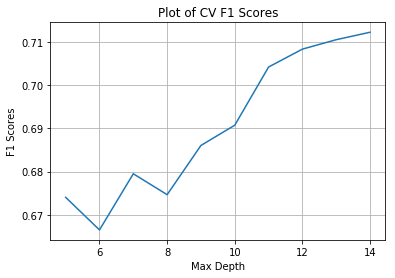

Dimensions of X_test is (15000, 25015) and y_test is (15000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.76      0.76      0.76      8253
   positive       0.71      0.70      0.70      6747

avg / total       0.73      0.73      0.73     15000

Confusion Matrix is .....


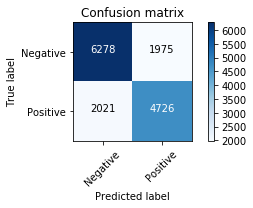

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.895518 to fit

Top 10 features are: 
       FeatureName  FeatureImp
9314        great    0.109501
1980         best    0.087737
6091   disappoint    0.085916
12729        love    0.070279
5643       delici    0.044986
21635        tast    0.035445
7410        excel    0.032222
13983       money    0.031370
16137     perfect    0.028153
1494          bad    0.025591
18:15:24


In [141]:
# no_of_records=364171
no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='bow')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

## TF-IDF

In [137]:
def vectorize_tfidf(X_train, X_test):
    #Vectorize the reviews
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    
    #Build vocabulary from X_train
    X_train_counts = tf_idf_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = tf_idf_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, tf_idf_vect

18:15:44
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Shape of vectorized train and test datasets are (35001, 637804) and (15000, 637804)
Number of unique words in the dataset is  637804
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 35001 with 637804 features each
The shape of vectorized test dataset is (15000, 637804)
Max features are 318902

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


Calculating best score from grid search...
Best score:  0.7160461151410078
Best parameters set:
max_depth 13


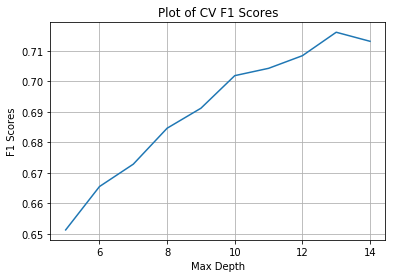

Dimensions of X_test is (15000, 637804) and y_test is (15000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.74      0.82      0.78      8253
   positive       0.74      0.64      0.69      6747

avg / total       0.74      0.74      0.74     15000

Confusion Matrix is .....


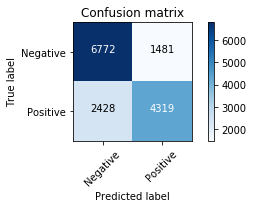

Top 10 features are: 
            FeatureName  FeatureImp
245534           great    0.124451
49606             best    0.100783
155540      disappoint    0.093433
327728            love    0.087028
145395          delici    0.047612
553043            tast    0.045248
356914           money    0.039223
264069  high recommend    0.032738
188794           excel    0.028960
407360         perfect    0.028770
18:26:14


In [142]:
no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='tfidf')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

## Word2Vec
There are 2 ways to do word2vec
1. Use Google's model which was built using Google's news dataset. Since this was built from a large dataset, this gives us a 300 dimension vector which will be richer.
2. Train our own model. Since we have a small dataset, we can build a 50 dimensional vector with this.
We will try both ways below

As a first step we need to build a list of sentence from the Word2VecText we have saved earlier. This will be used to get the vectors from Google's model as well as the one that we are going to build

In [143]:
def get_w2vdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT time, Word2VecText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT time, Word2VecText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))

    return data

#### Train our own Word2Vec model

In [144]:
def build_word2vec(train_list_of_sent):
    # Train your own Word2Vec model using your own text corpus
    w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4)

    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model, w2v_words

#### Average Word2Vec With our own model

In [145]:
def vectorize_Oavgw2v(X_train, X_test):
    train_list_of_sent=[]
    test_list_of_sent=[]
    print ('Splitting train data into sentences.....')
    for sent in X_train['Word2VecText'].values:
        train_list_of_sent.append(sent.split())
    
    print ('Splitting test data into sentences.....')
    for sent in X_test['Word2VecText'].values:
        test_list_of_sent.append(sent.split())
        
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(train_list_of_sent)

    print ('Vectorizing train data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    
    train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in train_list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        train_sent_vectors.append(sent_vec)

    print ('Vectorizing test data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in test_list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_sent_vectors.append(sent_vec)
    print('Completed vectorizing at {}'. format(datetime.now()))
    
    #convert to sparse matrix
    X_train_counts = sparse.csr_matrix(np.array(train_sent_vectors))
    X_test_counts = sparse.csr_matrix(np.array(test_sent_vectors))
        
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized reviews contain {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data

18:37:09
Positive reviews shape is (50000, 3)
Negative reviews shape is (50000, 3)
Both positive and negative reviews combined together contains 100000 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Starting vectorizing at 2018-11-01 18:37:18.225387
Vectorizing test data.....
Starting vectorizing at 2018-11-01 18:39:28.087026
Completed vectorizing at 2018-11-01 18:40:17.595870
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 70001 with 50 features each
The shape of vectorized test dataset is (30000, 50)
Max features are None

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


Calculating best score from grid search...
Best score:  0.7791195791881378
Best parameters set:
max_depth 8


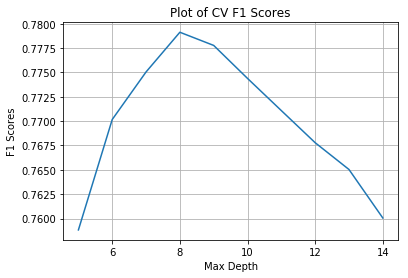

Dimensions of X_test is (30000, 50) and y_test is (30000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.85      0.77      0.81     18875
   positive       0.67      0.76      0.71     11125

avg / total       0.78      0.77      0.77     30000

Confusion Matrix is .....


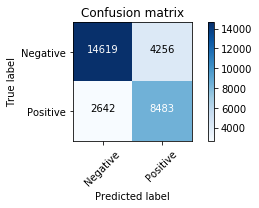

18:42:07


In [150]:
# no_of_records=364171
no_of_records=100000

print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Oavgw2v')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

#### TF-IDF weighted Word2Vec With our own model

In [151]:
def vectorize_Otfidfw2v(X_train, X_test):
    # TF-IDF weighted Word2Vec
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    tf_idf_counts = tf_idf_vect.fit_transform(X_train['Word2VecText'].values)
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


    tfidf_feat = tf_idf_vect.get_feature_names() 
    
    train_list_of_sent=[]
    test_list_of_sent=[]
    print ('Splitting train data into sentences.....')
    for sent in X_train['Word2VecText'].values:
        train_list_of_sent.append(sent.split())
    
    print ('Splitting test data into sentences.....')
    for sent in X_test['Word2VecText'].values:
        test_list_of_sent.append(sent.split())
        
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(train_list_of_sent)
    
    print ('Vectorizing train data.....')
    train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in train_list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        train_sent_vectors.append(sent_vec)
        row += 1

    print ('Vectorizing test data.....')
    test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in test_list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        test_sent_vectors.append(sent_vec)
        row += 1

    X_train_counts = sparse.csr_matrix(np.array(train_sent_vectors))
    X_test_counts = sparse.csr_matrix(np.array(test_sent_vectors))
        
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized reviews contain {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data

18:42:36
Positive reviews shape is (50000, 3)
Negative reviews shape is (50000, 3)
Both positive and negative reviews combined together contains 100000 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Vectorizing test data.....
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 70001 with 50 features each
The shape of vectorized test dataset is (30000, 50)
Max features are None

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Calculating best score from grid search...
Best score:  0.7522766439320797
Best parameters set:
max_depth 8


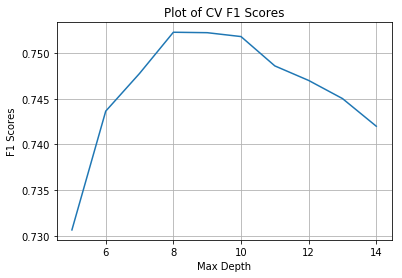

Dimensions of X_test is (30000, 50) and y_test is (30000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.84      0.68      0.75     18875
   positive       0.59      0.78      0.67     11125

avg / total       0.75      0.71      0.72     30000

Confusion Matrix is .....


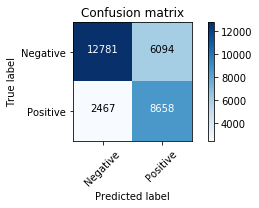

18:47:43


In [152]:
# no_of_records=364171
no_of_records=100000
print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Otfidfw2v')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))


|Model|Type of Search|Best Parameters |Train F1 Score|Test F1 Score|Top 10 words|
|---:| ------------- |:-------------:| -----:|-----:|-----:|-----:|
|BagOfWords|GridSearch|Max Depth = 14|0.7122123044264468|	0.73|great, best, disappoint, love, delici, tast, excel, money, perfect and bad|
|TfIDF|GridSearch|Max Depth = 13|0.7160461151410078|	0.74|great, best, disappoint, love, delici, tast, money, high recommend, excel and perfect|
|AverageWord2Vec|GridSearch|Max Depth = 8|0.7791195791881378|	0.77|NA|
|TFIDF Weighted Word2Vec|GridSearch|Max Depth = 8|0.7522766439320797|	0.72|NA|